<a href="https://www.kaggle.com/code/sonnylowe/new-titanic-simple-deep-learning-tutorial?scriptVersionId=180998688" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Titanic - Simple Deep Learning Tutorial**

Welcome! This simple tutorial walks you through simple data processing and using Kera's Sequential framework to generate a deep neural network to model our data. You will learn basic concepts and develop a baseline model that is impressive in accuracy. Nevertheless, you are encouraged to experiment with the data and the model to generate a more accudate prediction. 

If you learned something, please upvote to support these types of tutorials!

By Sonny Lowe

# File Processing:
Reading the input file csv.

In [87]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Data Processing:

Our data processing is split in two steps: one predefined custom function for the more complex data columns (ie name, ticket, etc), and then a processing keras pipeline for general numerical and categorical data. 

First, our custom function, called preprocess, isolates the prefix in a name (miss, mr, mrs) and places it into its own column. It also splits the ticket into the ticket number and its class (item).

Finally, we will split the data into two sections, **training** and **validation**. The size of the training versus validation sections can be specified through the *train_size* property.

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

file_path = '../input/titanic/train.csv'
data = pd.read_csv(file_path)
data.head()

X = data.copy()
y = X.Survived

def preprocess(df):
    df = df.copy()
    
    def prefix(x):
        name = x.split(",")
        return (name[1].split(" ")[1])[:-1]
    
    def normalize_name(x):
        name = " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
        return name.split(" ")[0] + " " + " ".join(name.split(" ")[2:])
    
    def ticket_number(x):
        num = x.split(" ")[-1]
        if(num.isnumeric()):
            return num
        return 0
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    df["Prefix"] = df["Name"].apply(prefix)
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
        
    return df

X = preprocess(X)

prefix_possibilities = X['Prefix'].unique()
print(prefix_possibilities)

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.70)

X.head()

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'th' 'Jonkheer']


PassengerId  Survived  Pclass                                         Name  \
0            1         0       3                           Braund Owen Harris   
1            2         1       1  Cumings John Bradley Florence Briggs Thayer   
2            3         1       3                              Heikkinen Laina   
3            4         1       1         Futrelle Jacques Heath Lily May Peel   
4            5         0       3                          Allen William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  \
0    male  22.0      1      0         A/5 21171   7.2500   NaN        S   
1  female  38.0      1      0          PC 17599  71.2833   C85        C   
2  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S   
3  female  35.0      1      0            113803  53.1000  C123        S   
4    male  35.0      0      0            373450   8.0500   NaN        S   

  Prefix Ticket_number Ticket_item  
0     Mr         21171         A/5  
1    Mrs         17599          PC  
2   Miss       3101282    STON/O2.  
3    Mrs        113803        NONE  
4     Mr        373450        NONE

The features are split into two cartegories for pipeline processing - **Numberical** and **Categorical**.
- A data **pipeline** takes in raw data and processes it into the desired format using a fixed framework
- This framework first **imputes** the numerical data by substituting missing data with a different value. Then it **scales** it to unit variance.
- For categorical data, it uses **OneHotEncoding** to transform categorical data to multiple columns of each possible unique entry, with a 0 if it exists and a 1 if it does not. See the diagram below:

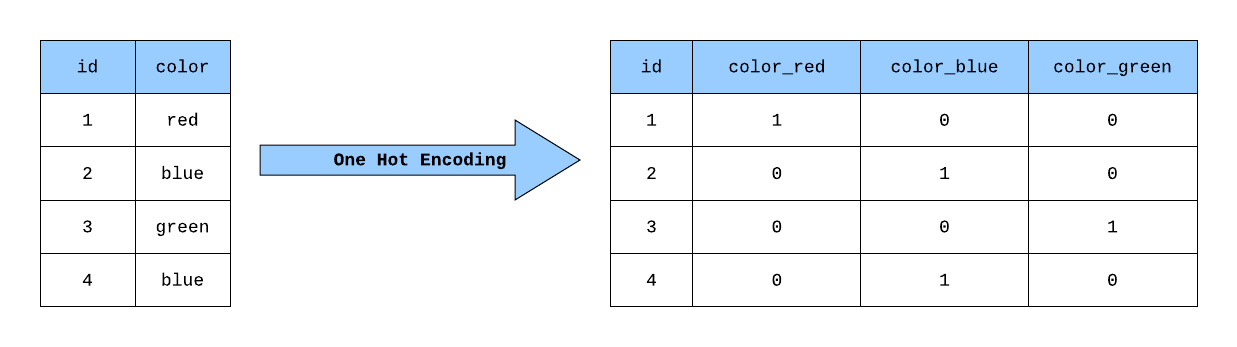

In [89]:
features_num = [
    'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Ticket_number'
]

features_cat = [
    'Sex', 'Embarked', 'Prefix'
]

# these are features that we want to keep but need not process. In this case, it is empty but feel free to add some
features_other = [
]

transformer_num = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
    ('passthrough', features_other)
)

processed_X_train = preprocessor.fit_transform(X_train)
processed_X_valid = preprocessor.transform(X_valid)

df = pd.DataFrame(X_train)
df.head()

PassengerId  Survived  Pclass  \
644          645         1       3   
307          308         1       1   
137          138         0       1   
162          163         0       3   
602          603         0       1   

                                                  Name     Sex    Age  SibSp  \
644                                    Baclini Eugenie  female   0.75      2   
307  Penasco Castellana Mrs Victor de Satode Maria ...  female  17.00      1   
137                             Futrelle Jacques Heath    male  37.00      1   
162                              Bengtsson John Viktor    male  26.00      0   
602                               Harrington Charles H    male    NaN      0   

     Parch    Ticket      Fare Cabin Embarked Prefix Ticket_number Ticket_item  
644      1      2666   19.2583   NaN        C   Miss          2666        NONE  
307      0  PC 17758  108.9000   C65        C    Mrs         17758          PC  
137      0    113803   53.1000  C123        S     Mr        113803        NONE  
162      0    347068    7.7750   NaN        S     Mr        347068        NONE  
602      0    113796   42.4000   NaN        S     Mr        113796        NONE

# Model
Using Keras, we will create the structure of our neural network. Determining the amount of layers, dropout layers, and batch normalizations is a complex process, and you are encouraged to experiment with the structure. The given structure is by no means an optimal one.

This model uses two basic types of layers
- **Dense layers:** these are the most basic layers of a neural network that are composed of nodes (neurons) that take inputs and linearly alters it to an output (very simplified explanation). Then, they each will have an activation function that essentially places a kink in the linearly path to allow the model to stray from pure line.
- **Dropout Layers:** A dropout layer is a layer in a neural network that randomly sets some input units to zero during training to help prevent overfitting. This is done with a defined probability, or rate, which is specified through the *rate* property.

You may also experiment with batch normalization layers:
- **Batch Normalization:** Batch normalization is a technique that normalizes the inputs of each layer in a deep neural network to improve training speed and stability.

In [90]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

This model's goal is a binary output - 0 for death and 1 for survival. Therefore, when **compiling** this model, we can specify our loss function and metric to be of binary nature. A loss function is the function that the model will attempt to minimize, which can be thought of as a measure of departure from accuracy. Obviously, we will attempt to minimize this departure.

In addition, to prevent overfitting, we have an **early_stopping** function. Essentially, we can specify how many epochs to wait (*patience*) without a minimum improvement (*min_delta*) in order to prematurely stop the compilation. You can play around with these properties too.

Finally, we will track the **history** of our model and how many *epochs* (versions) to run it for. This number is unnecessarily large, as we are relying on our early stopping function to terminate the running. You can also change the batch_sizes, which is how much data it looks at for each iteration in an epoch. (Every epoch is made of many iterations towards the best possible accuracy)

In [91]:
model.compile(
    optimizer='adamax',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    processed_X_train, y_train,
    validation_data=(processed_X_valid, y_valid),
    batch_size=512,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - binary_accuracy: 0.6171 - loss: 0.6826 - val_binary_accuracy: 0.6157 - val_loss: 0.6283
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - binary_accuracy: 0.6158 - loss: 0.6210 - val_binary_accuracy: 0.6679 - val_loss: 0.5885
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - binary_accuracy: 0.6584 - loss: 0.5751 - val_binary_accuracy: 0.7052 - val_loss: 0.5544
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.7188 - loss: 0.5269 - val_binary_accuracy: 0.7649 - val_loss: 0.5254
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - binary_accuracy: 0.7942 - loss: 0.4968 - val_binary_accuracy: 0.7910 - val_loss: 0.5067
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - binary_accuracy: 0.8138 - loss: 0.4546 - val_binary_accuracy: 0.7836 - val_loss: 0.5033
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - binary_accuracy: 0.8190 - loss: 0.4484 - val_binary_accuracy: 0.7948 - val_loss: 0.5082
Epoch 8/100
2/2 ━━━

Now, we can plot this history.

Best Validation Loss: 0.4574
Best Validation Accuracy: 0.8134


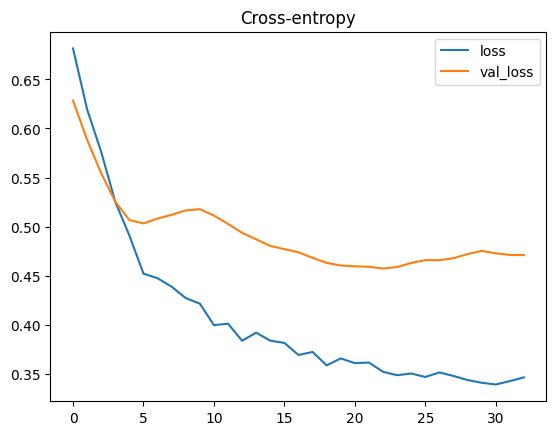

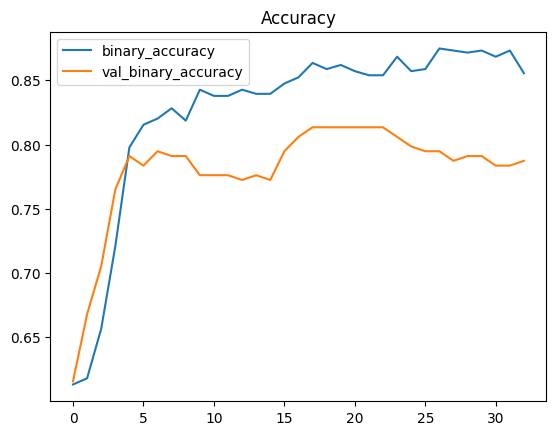

In [92]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

# Predicting

Using our established data processing pipeline, we can process the given testing data. Then, we will use the model with the best accuracy across epochs, as our early stopping function tracks, to determine predictions.

The final step is writing the predictions into an output file to submit. It is now ur job to get a better score than we have here! Good Luck!

In [93]:
subm_path = '../input/titanic/test.csv'

data = pd.read_csv(subm_path)
test_data = data.copy()

test_data = preprocess(test_data)
test_data = preprocessor.transform(test_data)

final_preds = np.round(np.clip(model.predict(test_data), 0, 1))

output = pd.DataFrame({
    'PassengerId': data.PassengerId,
    'Survived': final_preds[:, 0].astype(int)
})

#output.to_csv('submission.csv', index=False)

#output = pd.read_csv('submission.csv')
#output.head()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


# Bonus Section
Taking the Majority Guess of Many Models

In [94]:
def train_model(X, y, test_data):

    X_train, X_valid, p_y_train, p_y_valid = \
        train_test_split(X, y, stratify=y, train_size=0.75)
    
    p_X_train = preprocessor.fit_transform(X_train)
    p_X_valid = preprocessor.transform(X_valid)
    pred_data = test_data.copy()
    pred_data = preprocessor.transform(pred_data)
    
    new_model = keras.Sequential([
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])
    new_model.compile(
        optimizer='adamax',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )
    new_history = new_model.fit(
        p_X_train, p_y_train,
        validation_data=(p_X_valid, p_y_valid),
        batch_size=512,
        epochs=100,
        callbacks=[early_stopping],
        verbose=0
    )

    preds = np.round(np.clip(new_model.predict(pred_data), 0, 1))
    histories.append(new_history)
    return preds
    

In [95]:
histories = []

file_path = '../input/titanic/train.csv'
data = pd.read_csv(file_path)

X = data.copy()
y = X.Survived
X = preprocess(X)

subm_path = '../input/titanic/test.csv'
test_data = pd.read_csv(subm_path)
test_data = preprocess(test_data)

# arrays to track the number of predictions for a passenger to have died or survived
# the final prediction will be determined by which prediction is more frequent with tiebreaks for dying
dead = []
survived = []

# change the range for how many models you want to create - the more models the more time
for x in range(9):
    preds = train_model(X, y, test_data)
        
    for i in range(0, len(preds)):
        if(x == 0):
            if (preds[i] == 0):
                dead.append(1)
                survived.append(0)
            else:
                dead.append(0)
                survived.append(1)
        else:
            if (preds[i] == 0):
                dead[i] += 1
            else:
                survived[i] += 1

print("Binary Accuracies:")
for x in range(0, len(histories)):
    history_df = pd.DataFrame(histories[x].history)
    print(history_df['val_binary_accuracy'].max())

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Binary Accuracies:
0.8385650515556335
0.8609865307807922
0.8116592168807983
0.8430493474006653
0.8116592168807983


In [96]:
final_preds = []

for i in range(0, len(dead)):
    if(dead[i] >= survived[i]):
        final_preds.append(0)
    else:
        final_preds.append(1)
        
output = pd.DataFrame({
    'PassengerId': test_data.PassengerId,
    'Survived': final_preds
})

output.to_csv('submission.csv', index=False)

output = pd.read_csv('submission.csv')
output.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1